# CRS Canada immigration metrics analysis
We investigate the Comprehensive Ranking Systme (CRS) metrics that canada uses to grant permanent residence invitations and project predicted cutoff values for the incoming cohort.

We essentially:
1. Scrub the website and create the pandas dataframe
2. Clean up the data
3. Create the preprocessing variables
4. Fit a model
5. Evaluate the goodness of fit

In [68]:
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

## Creating the pandas dataframe
When we scrape the data from the website, we start with a json file saved in their system which is used to populate dynamic tables on their site.
To properly transform and rename the columns into readable/printable data, we need to adjust datatypes and others.

In [69]:
def create_df_from_website(url):
    ''' 
    This function scrapes data from the website and converts it to a usable pandas framework.
    '''
    # read in json filetype
    r = requests.get(url)
    rounds = r.json()['rounds']
    # remove commas from integer strings
    for r in rounds:
        for i in r:
            r[i] = r[i].replace(",", "")
    # create pandas df from dictionary
    df = pd.DataFrame.from_dict(rounds,dtype='string')
    # specify column names as needed
    columns={"drawNumber": "id", 
             "drawDate": "date", 
             "drawName": "round type", 
             "drawSize":"invitations issued", 
             "drawCRS": "CRS cutoff",
             "drawText2": "type issued",
             "drawCutOff": "tie break rule",
             "dd18": "total applications",
             "dd1":  "crs_range_601_1200",
             "dd2":  "crs_range_501_600",
             "dd3":  "crs_range_451_500",
             "dd4":  "crs_range_491_500",
             "dd5":  "crs_range_481_490",
             "dd6":  "crs_range_471_480",
             "dd7":  "crs_range_461_470",
             "dd8":  "crs_range_451_460",
             "dd9":  "crs_range_401_450",
             "dd10": "crs_range_441_450",
             "dd11": "crs_range_431_440",
             "dd12": "crs_range_421_430",
             "dd13": "crs_range_411_420",
             "dd14": "crs_range_401_410",
             "dd15": "crs_range_351_400",
             "dd16": "crs_range_301_350",
             "dd17": "crs_range_000_300",
             }
    # specify dtypes as needed
    dtypes={#"drawNumber": "id", 
            "drawDate": "datetime64[ns]", 
            #"drawName": "round type", 
            "drawSize":"int64", 
            "drawCRS": "int64",
            #"drawText2": "type issued",
            #"drawCutOff": "tie break rule",
            "dd18": "int64",
            "dd1":  "int64",
            "dd2":  "int64",
            "dd3":  "int64",
            "dd4":  "int64",
            "dd5":  "int64",
            "dd6":  "int64",
            "dd7":  "int64",
            "dd8":  "int64",
            "dd9":  "int64",
            "dd10": "int64",
            "dd11": "int64",
            "dd12": "int64",
            "dd13": "int64",
            "dd14": "int64",
            "dd15": "int64",
            "dd16": "int64",
            "dd17": "int64",
            }
    #set names and dtypes
    df = df.astype(dtype=dtypes)
    df = df.rename(columns=columns)
    # extract only columns of interest
    vars_to_keep=['date','round type','invitations issued','CRS cutoff']
    df= df[vars_to_keep]

    return df

def cleanup_df_general_rounds(df):
    ''' 
    this function extracts only the general rounds and cleans up data slightly
    '''
    # combine general rounds into one type
    df["round type"] = df["round type"].replace({'No Program Specified': 'General'})
    # extract gral rounds only and remove outliers
    df = df[(df["round type"] == "General") & ((df["CRS cutoff"] < 700) & (df["CRS cutoff"] > 100))]

    return df

def calculate_date_vars(df):
    ''' 
    this function calculates extra variables based on date
    '''
    # get date column
    try:
        dates = df['date']
    except:
        dates = df.index.to_series()
    # get vars
    df['Month'] = dates.dt.month
    df['Year'] = dates.dt.year
    df['dayofweek'] = dates.dt.dayofweek
    df['quarter'] = dates.dt.quarter

    return df


def calculate_rolling_averages(df,roll_times=['30D','60D','90D','180D']):
    ''' 
    This function calculates the rolling averages point wise for the uneven datetimes
    '''
    #setup date itself as the index
    df = df.set_index('date').copy()
    # flip data from oldest to newest
    df = df.iloc[::-1]
    # get mean CRS in the past N months prior to this value
    for r in roll_times:
        df['roll_'+r] = df['CRS cutoff'].rolling(r, min_periods=1,closed='left').mean()
    # flip from new to old
    df = df.iloc[::-1]

    return df

def calculate_offset_windows(df,offset_value=[-1]):
    # remove nans so that you dont use their datetimes
    df = df.dropna().copy()
    # get date column
    try:
        dates = df['date']
    except:
        dates = df.index.to_series()
    # get window per each offset values
    for offset in offset_value:
        #add previous CRS
        df['CRS'+str(offset)] = df['CRS cutoff'].shift(offset)
        #calculate quickly dt
        df['dt'+str(offset)] = dates.diff().abs().shift(offset).dt.days
    
    return df.dropna()

def split_test_train(df,split_date='01-Jan-2023'):
    ''' 
    this function splits the time series into test and train data based on a cutoff date
    '''
    # get date column
    try:
        dates = df['date']
    except:
        dates = df.index.to_series()
    # split it
    data_train = df.loc[dates <= split_date].copy()
    data_test = df.loc[dates > split_date].copy()
    return data_train, data_test

def create_features(data,x_labels=['dt-1','CRS-1'],y_labels=['CRS cutoff']):
    ''' 
    This function creates X and Y features
    '''
    X = data[x_labels]
    Y = data[y_labels]
    return X, Y

In [77]:

url = 'https://www.canada.ca/content/dam/ircc/documents/json/ee_rounds_123_en.json'
df = create_df_from_website(url)
df = cleanup_df_general_rounds(df)
#df = calculate_date_vars(df)
dtrain, dtest = split_test_train(df)
dtrain = calculate_rolling_averages(dtrain)
dtrain = calculate_offset_windows(dtrain)

dtest = calculate_rolling_averages(dtest)
dtest = calculate_offset_windows(dtest)

x_labels=['roll_30D','roll_60D','roll_90D','dt-1','CRS-1']
X_train, y_train = create_features(dtrain,x_labels=x_labels)
X_test, y_test = create_features(dtest,x_labels=x_labels)

In [80]:
X_train

,roll_30D,roll_60D,roll_90D,dt-1,CRS-1
date,,,,,
2022-11-23,495.000000,498.500000,503.333333,14.0,494.0
2022-11-09,498.000000,502.500000,508.500000,14.0,496.0
2022-10-26,502.000000,507.500000,514.666667,14.0,500.0
2022-10-12,507.000000,513.750000,521.666667,14.0,504.0
2022-09-28,513.000000,521.000000,530.500000,14.0,510.0
...,...,...,...,...,...
2015-07-17,466.000000,471.333333,471.333333,7.0,463.0
2015-07-10,475.500000,475.500000,468.000000,14.0,469.0
2015-06-26,482.000000,482.000000,468.000000,70.0,453.0


In [74]:
# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the response on test
data_test['CRS Prediction'] = model.predict(X_test)

,CRS cutoff
date,
2024-04-23,529
2024-04-10,549
2024-03-25,524
2024-03-12,525
2024-02-28,534
2024-02-13,535
2024-01-31,541
2024-01-23,543
2024-01-10,546


<Axes: title={'center': ' CRS cutoff scores'}, xlabel='date'>

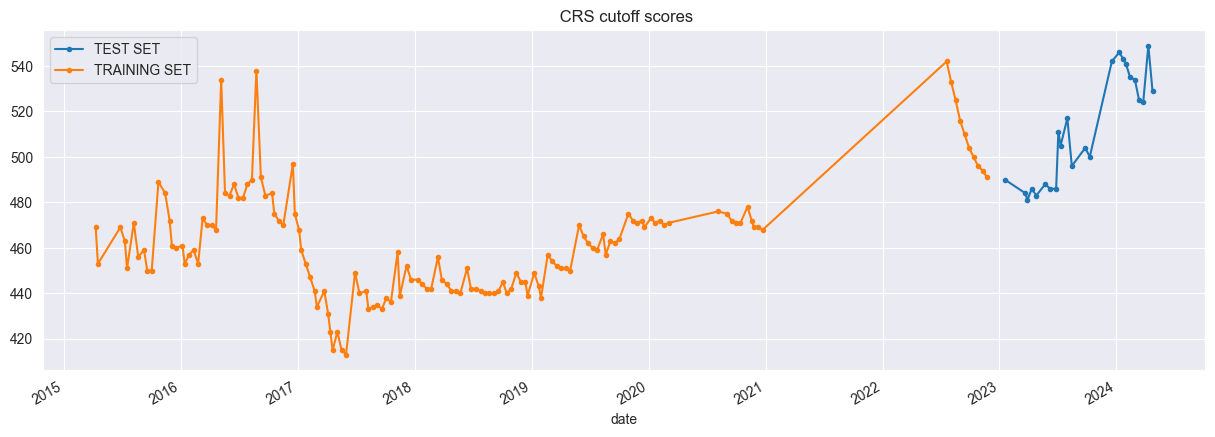

In [1629]:
data_joined = data_test[['CRS cutoff']].rename(columns={'CRS cutoff': 'TEST SET'})\
.join(data_train[['CRS cutoff']].rename(columns={'CRS cutoff': 'TRAINING SET'}),how='outer')

data_joined.plot(figsize=(15,5), title=' CRS cutoff scores', style='.-')

In [1631]:
# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the response on test
data_test['CRS Prediction'] = model.predict(X_test)

RMSE for Linear Regression: 12.600


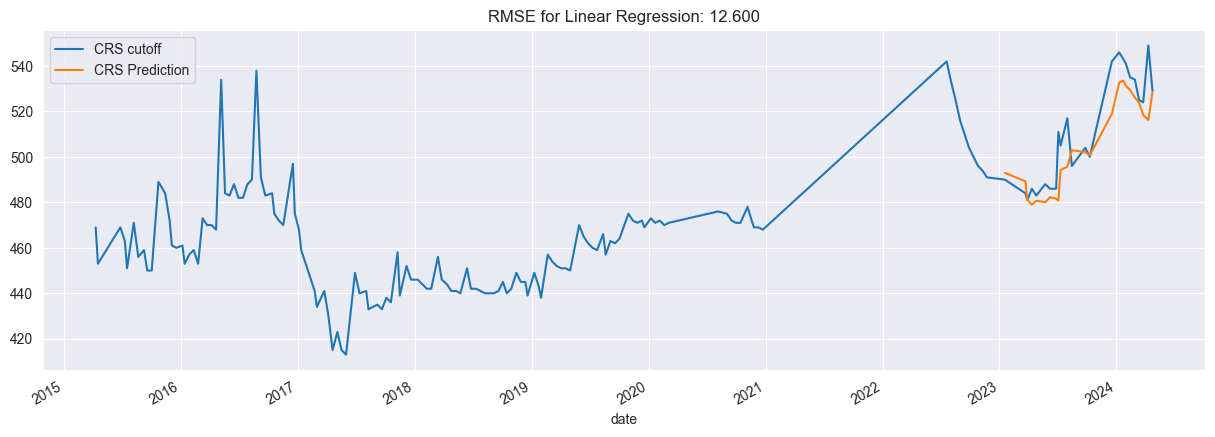

In [1632]:
# calculate the RMSE
rmse = root_mean_squared_error(y_true=data_test['CRS cutoff'],
                   y_pred=data_test['CRS Prediction'])

title = f'RMSE for Linear Regression: {rmse:.3f}'
print(title)


# plot the linear regression
data_all = pd.concat([data_test, data_train], sort=False)
_ = data_all[['CRS cutoff','CRS Prediction']].plot(figsize=(15, 5), title = title)



In [1633]:
#ML libraries
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [1634]:

# fit XGBRegressor
model = xgb.XGBRegressor(n_estimators=500)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

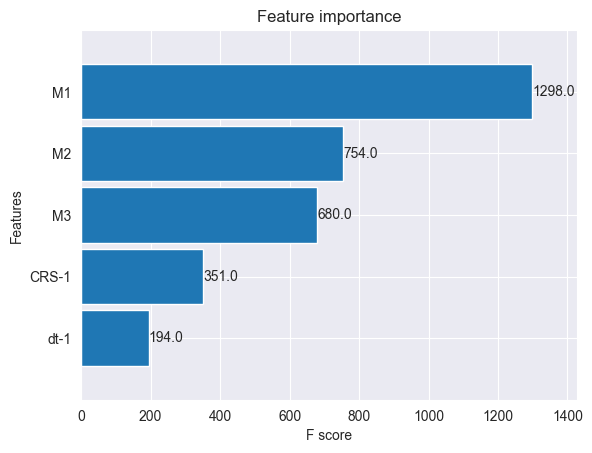

In [1635]:
_ = plot_importance(model, height=0.9)

RMSE for XGBoost: 17.931


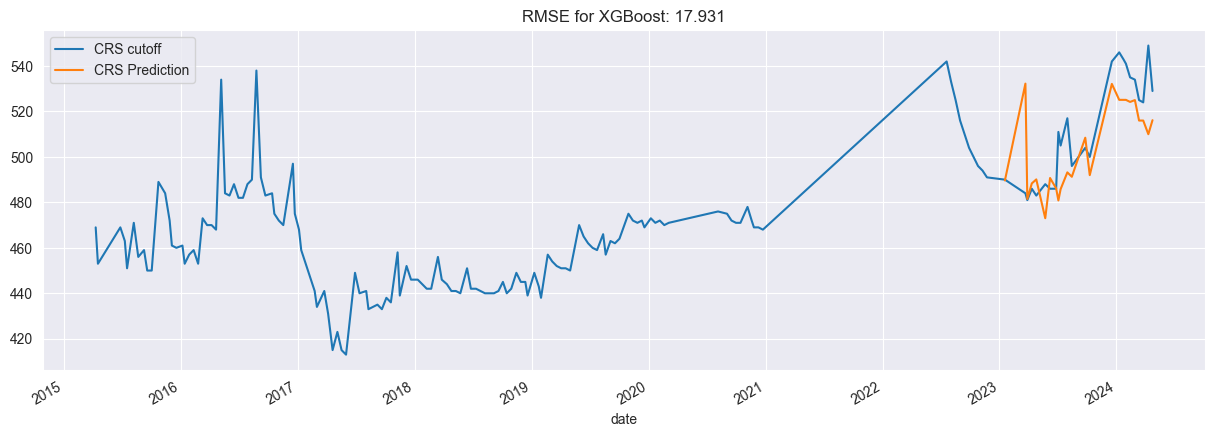

In [1636]:
# predict the response on test
data_test['CRS Prediction'] = model.predict(X_test)

# calculate RMSE
rmse = root_mean_squared_error(y_true=data_test['CRS cutoff'],
                   y_pred=data_test['CRS Prediction'])
title = f'RMSE for XGBoost: {rmse:.3f}'
print(title)


# plot it
data_all = pd.concat([data_test, data_train], sort=False)
_ = data_all[['CRS cutoff','CRS Prediction']].plot(figsize=(15, 5), title = title)


## Conclusion
For the needs of this model, we need a good ballpark within 10~20 points of the actual cutoff. It seems that both the linear regression model and XGBoost do a decent job, however the linear regression model when plotted is cleaner and more elegant.

Also, given that the linear regression is the simplest of the two, we will move forward with sending to production the LR model and work with that one from now on. We will continue monitoring XGBoost in case that one eventually outperforms the LR one.

As a sidenote, this data is an unevently spaced time series, and given the fact that this is essentially a set of invites where we do not know when the next one will occur, we cannot safely make the assumption that interpolated data would work on this. If we look at the data, we can see several instances where the cutoff CRS changed dramatically after a couple of invites and back to the trend, so it is better to just retain the timeframes and data spacing as is.

In [ ]:
# # calculate dt
# df['dt-1'] = df['date'].diff().abs().shift(-1).dt.days
# df['dt-2'] = df['date'].diff(periods=2).abs().shift(-2).dt.days
# df['dt-3'] = df['date'].diff(periods=3).abs().shift(-3).dt.days
# df['dt-4'] = df['date'].diff(periods=4).abs().shift(-4).dt.days
# df['dt-5'] = df['date'].diff(periods=5).abs().shift(-5).dt.days
# df['dt-6'] = df['date'].diff(periods=6).abs().shift(-6).dt.days
# df['dt-7'] = df['date'].diff(periods=7).abs().shift(-7).dt.days
# df['dt-8'] = df['date'].diff(periods=8).abs().shift(-8).dt.days
# df['dt-9'] = df['date'].diff(periods=9).abs().shift(-9).dt.days

In [ ]:

# # create sliding windows
# df['CRS-1'] = df['CRS cutoff'].shift(-1)
# df['CRS-2'] = df['CRS cutoff'].shift(-2)
# df['CRS-3'] = df['CRS cutoff'].shift(-3)
# df['CRS-4'] = df['CRS cutoff'].shift(-4)
# df['CRS-5'] = df['CRS cutoff'].shift(-5)
# df['CRS-6'] = df['CRS cutoff'].shift(-6)
# df['CRS-7'] = df['CRS cutoff'].shift(-7)
# df['CRS-8'] = df['CRS cutoff'].shift(-8)
# df['CRS-9'] = df['CRS cutoff'].shift(-9)


In [ ]:
# create moving averages (Exponential moving averages EMA and Simple moving averages)
# df['EMA_9'] = df['CRS cutoff'].ewm(9).mean().shift(-1)
# df['SMA_2'] = df['CRS cutoff'].rolling(2).mean().shift(-2)
# df['SMA_4'] = df['CRS cutoff'].rolling(4).mean().shift(-4)
# df['SMA_6'] = df['CRS cutoff'].rolling(6).mean().shift(-6)
# df['SMA_12'] = df['CRS cutoff'].rolling(12).mean().shift(-12)


In [ ]:
# remove last n shifts with Nans Because of shifting CRS cutoff score and dt shifts
df = df_roll
df = df[:-12]      #
df

In [ ]:
_ = df[['date','CRS cutoff','CRS-3','SMA_6','SMA_12']].plot(x='date',figsize=(15, 5))

In [ ]:
#df['CRS cutoff'] = df['CRS cutoff'].shift(-1)
#df = df[:-1]      # Because of shifting CRS


In [ ]:
#split into train and test
split_date = '01-Jan-2023'
data_train = df.loc[df.date <= split_date].copy()
data_test = df.loc[df.date > split_date].copy()

def create_features(data,x_labels=['Month','Year'],y_labels=['CRS cutoff']):
    labels = x_labels+y_labels
    data_wo_na = data[labels].dropna()
    X = data_wo_na[x_labels]
    Y = data_wo_na[y_labels]
    return X, Y


In [ ]:

#x_labels = ['Month','Year','dayofweek','quarter','EMA_9','CRS-1','CRS-2','CRS-3','CRS-4','CRS-5','dt-1','dt-2','dt-3','dt-4','dt-5']
#x_labels = ['EMA_9','CRS-1','CRS-2','CRS-3','CRS-4','dt-1','dt-2','dt-3','dt-4','dt-5']
#x_labels = ['EMA_9','SMA_2','SMA_4','SMA_6','dt-1']#,'CRS-1','CRS-2','CRS-3','CRS-4','dt-1','dt-2','dt-3','dt-4','dt-5']
x_labels = ['SMA_12','SMA_6','SMA_2','SMA_4']#,'Month','Year','CRS-1','CRS-2','CRS-3','CRS-4','CRS-5','CRS-6','CRS-7','CRS-8','CRS-9','dt-1','dt-2','dt-3','dt-4','dt-5','dt-6','dt-7','dt-8','dt-9']
# x_labels = ['EMA_9','SMA_2','SMA_4','SMA_6','dt-1']

#x_labels = ['Month','Year','dayofweek','quarter','EMA_9','SMA_2','SMA_4','SMA_6']
#x_labels=['Month','Year']
X_train, y_train = create_features(data_train,x_labels=x_labels)
X_test, y_test = create_features(data_test,x_labels=x_labels)


In [ ]:
data_joined = data_test[['date','CRS cutoff']].rename(columns={'CRS cutoff': 'TEST SET'}).set_index('date')\
.join(data_train[['date','CRS cutoff']].rename(columns={'CRS cutoff': 'TRAINING SET'}).set_index('date'),how='outer')

data_joined.plot(figsize=(15,5), title=' CRS cutoff scores', style='.-')

In [ ]:
#ML libraries
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


In [ ]:
# linear regression just for fun, easiest one of all
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
# predict the response on test
data_test['CRS Prediction'] = model.predict(X_test)

# calculate the RMSE
rmse = root_mean_squared_error(y_true=data_test['CRS cutoff'],
                   y_pred=data_test['CRS Prediction'])

title = f'RMSE for Linear Regression: {rmse:.3f}'
print(title)


# plot the linear regression
data_all = pd.concat([data_test, data_train], sort=False)
_ = data_all[['CRS cutoff','CRS Prediction','date']].plot(x='date',figsize=(15, 5), title = title)



In [ ]:

# fit XGBRegressor
model = xgb.XGBRegressor(n_estimators=500)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train


In [ ]:
# predict the response on test
data_test['CRS Prediction'] = model.predict(X_test)

# calculate RMSE
rmse = root_mean_squared_error(y_true=data_test['CRS cutoff'],
                   y_pred=data_test['CRS Prediction'])
title = f'RMSE for XGBoost: {rmse:.3f}'
print(title)


# plot it
data_all = pd.concat([data_test, data_train], sort=False)
_ = data_all[['CRS cutoff','CRS Prediction','date']].plot(x='date',figsize=(15, 5), title = title)


In [ ]:

parameters = {
    'n_estimators': [100, 500],
    'learning_rate': [0.1, 0.5, 0.9],
    'max_depth': [10,15],
    'random_state': [42]
}

eval_set=[(X_train, y_train), (X_test, y_test)],

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


In [ ]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)


In [ ]:
_ = plot_importance(model, height=0.9)

In [ ]:
# predict the response on test
data_test['CRS Prediction'] = model.predict(X_test)

# calculate RMSE
rmse = root_mean_squared_error(y_true=data_test['CRS cutoff'],
                   y_pred=data_test['CRS Prediction'])
title = f'RMSE for XGBoost: {rmse:.3f}'
print(title)


# plot it
data_all = pd.concat([data_test, data_train], sort=False)
_ = data_all[['CRS cutoff','CRS Prediction','date']].plot(x='date',figsize=(15, 5), title = title)


